In [1]:
import torch
from torch import nn

import json
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import ROOT

import GAN
from defs import PROJECT_DIR
from defs import file_path_check

In [2]:
c = ROOT.TCanvas("c","2D plot",600,600)
c.cd()

output_file = PROJECT_DIR+"/out/moments/2DGaus.json"

# histogram parameters
xbins = 100
xlo = 250
xhi = 1250
ybins = 100
ylo = 0.25
yhi = 2.0
draw_opt = "LEGO30"

hs = ROOT.THStack("hs","2D Moment Morph")

# drawing variables and cuts
phi_var = "Obj_PhotonTwoProng.mass"
omega_var = "TwoProng_MassPi0[0]"
draw_str = omega_var+":"+phi_var+">>hist_2D_i"
cut_str = "nTwoProngs>0 && nIDPhotons>0 && Obj_PhotonTwoProng.dR>0.1 && Obj_PhotonTwoProng.part2_pt>150"

# Tree name in Ntuplizer files
tree_name = "twoprongNtuplizer/fTree"

In [3]:
file_list = [
    "${PROJECT_DIR}/root/Feb2021_PH-0500_OM-0p550.root",
#     "${PROJECT_DIR}/root/Feb2021_PH-0500_OM-0p950.root",
#     "${PROJECT_DIR}/root/Feb2021_PH-1000_OM-0p550.root",
#     "${PROJECT_DIR}/root/Feb2021_PH-1000_OM-0p950.root"
]

mass_list = [
    (500,0.55),
#     (500,0.95),
#     (1000,0.55),
#     (1000,0.95)
]

file_dict = {}
if len(file_list) != len(mass_list):
    print "list of root files and list of mass points are not the same length:"
    print "file_list: %i\tmass_list: %i"%(len(file_list),len(mass_list))
    quit()
# validate that all root files exist
for i in range(len(file_list)):
    f = file_path_check(file_list[i])
    file_dict[f] = mass_list[i]

In [4]:
def __thresh(hist,threshold=0.05):
    # cut out small bins
    hist_max = hist.GetBinContent(hist.GetMaximumBin())
    for bin_x in range(hist.GetNbinsX()):
        for bin_y in range(hist.GetNbinsY()):
            if hist.GetBinContent(bin_x,bin_y) < threshold*hist_max:
                hist.SetBinContent(bin_x,bin_y,0.)

In [5]:
moment_list = {}

# estimate 1st and 2nd gaussian moments for each distribution
for i,f in enumerate(file_dict.keys()):

    hist_2D_i = ROOT.TH2D("hist_2D_i","hist_2D_i",xbins,xlo,xhi,ybins,ylo,yhi)
    hist_2D_i.SetFillColor(22+(i-1)*8)
#     hist_2D_i.GetXaxis().SetTitle("PHI")
#     hist_2D_i.GetYaxis().SetTitle("OsMEGA")

    # draw .root data into histogram
    chain = ROOT.TChain(tree_name)
    chain.Add(f)
    chain.Draw(draw_str,cut_str,"goff")

    # remove non-peak bins
    __thresh(hist_2D_i,threshold=0.10)

    # normalize histogram
    hist_2D_i.Scale(1./hist_2D_i.Integral())

    # ROOT.gStyle.SetPalette(53+5*i)
    hs.Add(hist_2D_i.Clone())

    # fit histogram to 2D gaussian
    xy_gaus_i = ROOT.TF2("xy_gaus_i","xygaus",xlo,xhi,ylo,yhi)
    # xy_gaus_i.SetNpx(xbins)
    # xy_gaus_i.SetNpy(ybins)
    hist_2D_i.Fit("xy_gaus_i","SM")


    # hist_2D_i.Draw("COLZ0"+"SAME")
    # c.Update()

    # collect moments from parameters of 2D gaus fit
    moments = {}

    for i in range(1,xy_gaus_i.GetNpar()):
        moments[xy_gaus_i.GetParName(i)] = xy_gaus_i.GetParameter(i)

    # map mass to moments
    phi_mass = file_dict[f][0]
    omega_mass = file_dict[f][1]
    coord_string = "%4.1f,%1.2f"%(phi_mass,omega_mass)
    moment_list[coord_string] = moments
    
    # xy_gaus_i.Delete()
    hist_2D_i.Delete()

In [6]:
c.Clear()
c.Update()
# plotting
hs.Draw("LEGO30")
c.Update()
# hist_2D_tot.ShowPeaks(sigma=2,option="",threshold=0.05)
# c.Update()

with open(output_file,'w') as json_out:
    dump = json.dumps(moment_list,json_out,indent=4)
    print dump

{
    "500.0,0.55": {
        "SigmaY": 0.10768010217572185, 
        "MeanX": 493.35673492171054, 
        "SigmaX": 14.097526679322437, 
        "MeanY": 0.6048974085315212
    }
}


In [7]:
torch.manual_seed(100)

i=0
hist_i = hs.GetHists()[i]
xbins = hist_i.GetNbinsX()
ybins = hist_i.GetNbinsY()

train_data_length = xbins*ybins
train_data = torch.zeros((train_data_length,3))

xax = hist_i.GetXaxis()
yax = hist_i.GetYaxis()

lo = 0
hi = 0

count = 0
for xbin in range(xbins):
    x = xax.GetBinCenter(xbin)
    train_data[count:count+ybins+1] = x
#     print x
    for ybin in range(ybins):
        y = yax.GetBinCenter(ybin)
        train_data[count,1] = y
        train_data[count,2] = hist_i.GetBinContent(xbin,ybin)
        count += 1
#         print x,y,count,hist_i.GetBinContent(xbin,ybin)
        


# train_data[:,0] = 2*math.pi*torch.rand(train_data_length)
# train_data[:,1] = torch.sin(train_data[:,0])

train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i],train_labels[i]) for i in range(train_data_length)]

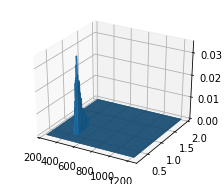

In [8]:
#check if data is correctly transferred
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(121,projection="3d")

x = train_data[:,0]
y = train_data[:,1]

width = (xlo-xhi)/xbins
depth = (ylo-yhi)/ybins

bottom = np.zeros(xbins*ybins)
top = train_data[:,2]

ax.bar3d(x,y,bottom,width,depth,top,shade=True)
plt.show()

# plt.contour(train_data[:,0],train_data[:,1])
# plt.plot(train_data[:,0],train_data[:,2],".")
# plt.plot(train_data[:,1],train_data[:,2],".")

In [9]:
batch_size = 10000
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)

generator = GAN.Generator()
discriminator = GAN.Discriminator()

lr = 0.001
num_epochs = 200
loss_function = nn.BCELoss()

optimizer_generator = torch.optim.Adam(generator.parameters(),lr=lr)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(),lr=lr)

In [10]:
for epoch in range(num_epochs):
    for n, (real_samples,_) in enumerate(train_loader):
        real_samples_labels = torch.ones((batch_size,1))
        latent_space_samples = torch.randn((batch_size,3))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size,1))
        all_samples = torch.cat((real_samples,generated_samples))
        all_samples_labels = torch.cat((real_samples_labels,generated_samples_labels))

        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator,all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        latent_space_samples = torch.randn((batch_size,3))

        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated,real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        if epoch % 25 == 0 and n == batch_size - 1:
            print "Epoch: %i Loss D.: %f"%(epoch,loss_discriminator)
            print "Epoch: %i Loss G.: %f"%(epoch,loss_generator)

Epoch: 0 Loss D.: 0.038061
Epoch: 0 Loss G.: 3.715638
Epoch: 25 Loss D.: 0.634066
Epoch: 25 Loss G.: 0.902798
Epoch: 50 Loss D.: 0.691392
Epoch: 50 Loss G.: 0.698412
Epoch: 75 Loss D.: 0.693093
Epoch: 75 Loss G.: 0.693056
Epoch: 100 Loss D.: 0.693515
Epoch: 100 Loss G.: 0.693201
Epoch: 125 Loss D.: 0.693127
Epoch: 125 Loss G.: 0.696038
Epoch: 150 Loss D.: 0.694303
Epoch: 150 Loss G.: 0.686606
Epoch: 175 Loss D.: 0.693104
Epoch: 175 Loss G.: 0.692944
Epoch: 200 Loss D.: 0.693379
Epoch: 200 Loss G.: 0.693464
Epoch: 225 Loss D.: 0.693282
Epoch: 225 Loss G.: 0.692623
Epoch: 250 Loss D.: 0.693007
Epoch: 250 Loss G.: 0.693328
Epoch: 275 Loss D.: 0.693159
Epoch: 275 Loss G.: 0.693316
Epoch: 300 Loss D.: 0.693259
Epoch: 300 Loss G.: 0.693095
Epoch: 325 Loss D.: 0.692995
Epoch: 325 Loss G.: 0.692885
Epoch: 350 Loss D.: 0.692956
Epoch: 350 Loss G.: 0.693108
Epoch: 375 Loss D.: 0.693116
Epoch: 375 Loss G.: 0.693299
Epoch: 400 Loss D.: 0.693213
Epoch: 400 Loss G.: 0.693333
Epoch: 425 Loss D.: 0.69

In [11]:
latent_space_samples = torch.randn(100,3)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()






# #check if data is correctly transferred
# fig = plt.figure(figsize=(8,3))
# ax = fig.add_subplot(121,projection="3d")

# x = generated_samples[:,0]
# y = generated_samples[:,1]

# width = (xlo-xhi)/xbins
# depth = (ylo-yhi)/ybins

# bottom = np.zeros(xbins*ybins)
# top = generated_samples[:,2]

# ax.bar3d(x,y,bottom,width,depth,top,shade=True)
# plt.show()

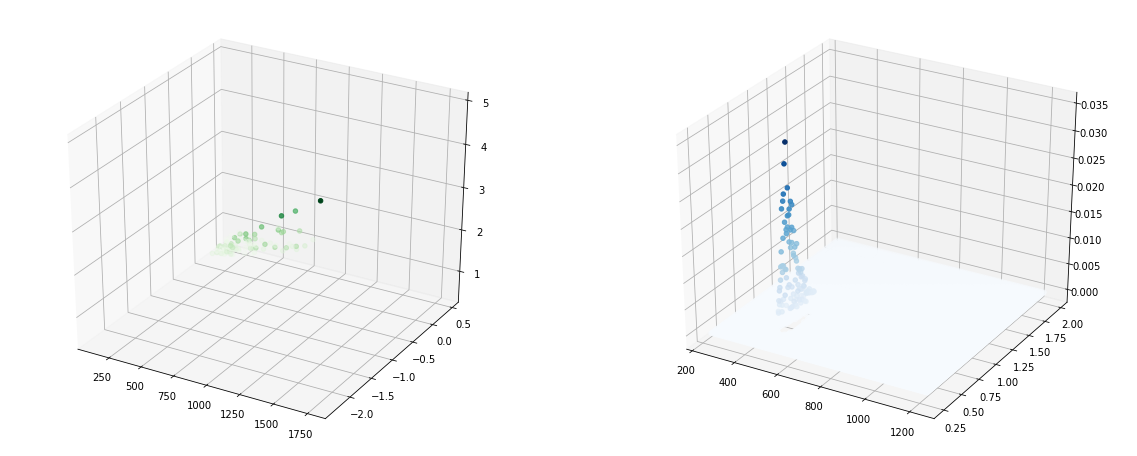

In [12]:
x_gen = generated_samples[:,0]
y_gen = generated_samples[:,1]
z_gen = generated_samples[:,2]

z_new = np.zeros((len(x_gen),len(x_gen)))

# show generated_samples

for z_i in range(len(z_gen)):
    x_v = x_gen[z_i]
    y_v = y_gen[z_i]
#     print "\n",x_v,y_v,z_gen[z_i]
#     print generated_samples[z_i,:]
    z_new[z_i,z_i] = z_gen[z_i]

fig = plt.figure(figsize=(20,8))



ax1 = fig.add_subplot(1,2,1,projection="3d")
ax1.scatter3D(x_gen,y_gen,z_gen,c=z_gen,cmap="Greens")
# plt.contourf(x_gen,y_gen,z_new,40)

ax2 = fig.add_subplot(1,2,2,projection="3d")
ax2.scatter3D(train_data[:,0],train_data[:,1],train_data[:,2],c=train_data[:,2],cmap="Blues")

In [13]:
hist_i_new = ROOT.TH2D("hist_i_new","Generated Sample Distribution",xbins,xlo,xhi,ybins,ylo,yhi)
hist_i_new.SetFillColor(50)

for i in range(len(x_gen)):
    hist_i_new.Fill(x_gen[i],y_gen[i],z_gen[i])
    

hist_i_new.DrawNormalized("LEGO30")
c.Update()